# Pipelines and oil spills: what data show

Dakota Access Pipeline is no longer an unfamiliar name. The controversy over the pipeline comes from two opposing views. On the one hand, people are of afraid of (water) pollution. On the contrary, the corporation responsible for the pipeline says it's safe. So the question is clear: Is the pipeline really safe? 

It's hard to answer this for a not operational pipeline, but we can look at pipeline incidents data to answer if *pipelines* are safe. Fortunately, the Pipeline and Hazardous Materials Safety (PHMS) Administration provides data on every single pipeline accidents from 1986 to now. The dataset is rich with a lot of raw data showing all kinds of details about the accidents. 

The analysis of the pipeline data is not unprecedented. The New York Times in 2014, created an interactive map of [environmental incidents in North Dakota](http://www.nytimes.com/interactive/2014/11/23/us/north-dakota-spill-database.html?_r=0) from 2006-2014. Back in 2015, [High Country News](http://www.scpr.org/news/2015/06/10/52332/santa-barbara-oil-spill-cleanup-costs-reach-69m-3m/) wrote a piece on crude oil spills after an incident in [Santa Barbara](http://www.scpr.org/news/2015/06/10/52332/santa-barbara-oil-spill-cleanup-costs-reach-69m-3m/) costing more than $62M at the time. Also after an incident in [North Dakota](http://insideenergy.org/2015/01/28/in-north-dakota-oilfield-spill-problems-worsen/), Inside Energy analyzed [wastewater spills in North Dakota](http://insideenergy.org/2015/01/30/wastewater-spills-in-north-dakota-what-the-data-tell-us/). All these articles emphasize that the spills are not as rare as one might think. 

This post is my take on the pipeline incidents. I'm interested in answering these specific questions:

1. How common are spills? 
2. What is their spatial and temporal distributions?
2. What is their scale regarding volume and cost?
2. What are the main causes of spills?
3. What places have a higher risk?

There are tons of other questions to ask, but these are basic questions to understand the problem better. Hopefully, similar studies are done for policy making.
As [Christofer Jones](http://www.christopherfjones.com/), historian of energy at ASU [points out](http://www.zocalopublicsquare.org/2015/06/11/theres-no-such-thing-as-a-spill-proof-way-to-transport-oil/ideas/nexus/): "While it’s true that improved technology and regulation have reduced spills significantly—much like flying today is far safer than in the early years of commercial aviation—the fact remains that there exists no such thing as a spill-proof pipeline. Recognizing this historical reality is crucial to crafting future policy."

## Dataset and technical details

I am doing the analysis in `Python` using its standard libraries:

* `numpy`
* `pandas`
* `matplotlib`

I also use `plotly`, but only for plotting points on the US map. I have customized `matplotlib` style using the recommendations of [this post](http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/).

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Helvetica Neue'
plt.rcParams['font.monospace'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

You can download the dataset from [PHMS website](http://www.phmsa.dot.gov/pipeline/library/data-stats/flagged-data-files) with `xlsx` format.  The dataset is broken into different time periods. Here I only focus on the data from 2010-2016 (filename is `hl2010toPresent`, converted to `CSV` format). Although, many incidents in 2016 are reported yet. This data contains massive details of each incident (having 255 columns for each record shows this!). I only select a few columns and rename them to be more descriptive:

* Year 
* Location (longitude and latitude)
* Commodity type
* The released volume (in barrels)
* State
* Release type
* Whether water was contaminated
* Total cost (in 1984 dollars)
* Cause

I make a few changes in the dataset to make it more approachable:

* The cost comes in 1984 dollar. According to [this website](http://www.in2013dollars.com/1984-dollars-in-2016?amount=1), \$1 in 1984 is equal to \$2.3 in 2016. 
* The released volume is in barrels, so I convert it to gallons which I have a better sense of (1 barrel = 42 US gallons).
* The commodity names are long, so I make them shorter.

In [8]:
usefulcols=["LOCAL_DATETIME","IYEAR","LOCATION_LATITUDE","LOCATION_LONGITUDE",
            "COMMODITY_RELEASED_TYPE","UNINTENTIONAL_RELEASE_BBLS","ONSHORE_STATE_ABBREVIATION",
            "RELEASE_TYPE","WATER_CONTAM_IND","TOTAL_COST_IN84","CAUSE"]
dataset = pd.read_csv("./datasets/hl2010toPresent.csv", usecols = usefulcols)

dataset.columns = ["time", "year", "lat", "long", "commodity", "volume","state", "release type", "water","cost","cause"]

dataset['commodity'].unique()
dataset['commodity'].replace(
    {'REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHICH IS A LIQUID AT AMBIENT CONDITIONS':'REFINED LIQUIDS',
    'CO2 (CARBON DIOXIDE)': 'CARBON DIOXIDE',
    'HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS A GAS AT AMBIENT CONDITIONS':'FLAMMABLE GASES',
    'BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)':'BIOFUEL'
    }
    , inplace=True)

# convert to gallons
dataset['volume'] = 42 * (dataset['volume'].astype(int))

# convert to 2016 dollars
dataset['cost'] = 2.3 * dataset['cost']

dataset.head(5)

,time,year,lat,long,commodity,volume,state,release type,water,cost,cause
0,2/16/10 7:42,2010,41.94352,-88.23353,REFINED LIQUIDS,0,IL,LEAK,NO,38379.865371,EQUIPMENT FAILURE
1,3/1/10 11:50,2010,37.10847,-100.80037,CARBON DIOXIDE,84,KS,OTHER,NO,4414.659264,OTHER INCIDENT CAUSE
2,2/22/10 10:38,2010,32.22471,-101.40440,FLAMMABLE GASES,42,TX,LEAK,NO,33782.834143,CORROSION FAILURE
3,2/19/10 6:50,2010,40.60860,-74.23990,REFINED LIQUIDS,0,NJ,LEAK,NO,21507.314365,EQUIPMENT FAILURE
4,2/21/10 12:45,2010,31.13284,-101.18974,CRUDE OIL,378,TX,LEAK,NO,21991.543373,CORROSION FAILURE


## Spread of spills

The first plot shows volume of the released commodities for all incidents in each year. Both plots are exactly the same, except the marker size is representing two different things. On the left plot, the size shows the cost of the spill. Unsuprisingly, the most costy incidents are those with a high volumem usually in range of $>10^4$.

The right panel, on the other hand, offers an alternative and intresting view. The size of each point is proportional to the cost of the spill devided by the release volume. This reveals a very intreting trend: The cost per volume is more for small spills! I don't know exactly why but my guess is the actions need to be taken are partly independent of the spill volume (this is up for debate, of course).

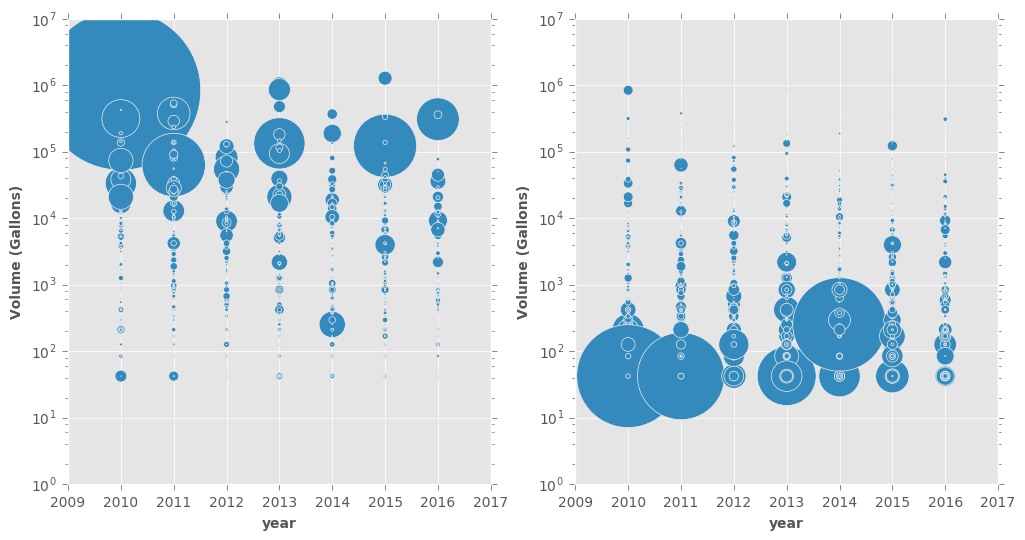

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
dataset.plot.scatter(x="year", y="volume",s=dataset.cost/80000,ax=axes[0])
dataset.plot.scatter(x="year", y="volume",s=0.04*dataset.cost/dataset.volume,ax=axes[1])
for ax in axes:
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_yscale('log')
    ax.set_xlim([2009,2017])
    ax.set_ylim([10**0,10**7])
    ax.set_ylabel('Volume (Gallons)')
plt.show()

Based on the commodity, the crude oil is the leading commodity that is released. Among 2693 incidents (roughly 1.5 incidents a day) reported from 2010 to October 2016, 1344 indicent involves releasing crude oil followed by refined fluid by 911 incidents. Together they make up ~$\%84$ of the incidents.

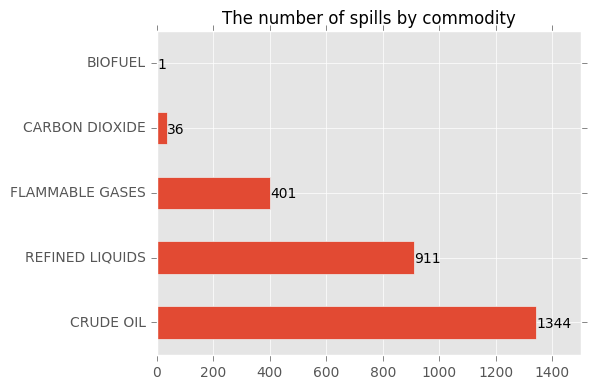

In [176]:
ax = dataset["commodity"].value_counts(sort=True).plot.barh()
ax.set_title("The number of spills by commodity")
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (1.1*p.get_x()+p.get_width(), p.get_y()+p.get_height()/3 ))
ax.set_xlim(0,1500)
plt.tight_layout()
plt.show()

It is worrying that number of the incidents has been constantly growing. Let's look at the data by year and the reason of spill. Obviousely _leak_ is the leading cause and unfortunately constantly number of the leaks is increasing. I tend to think this trends continue over to 2016 as well. Other causes have more or less the same frequency over the years.


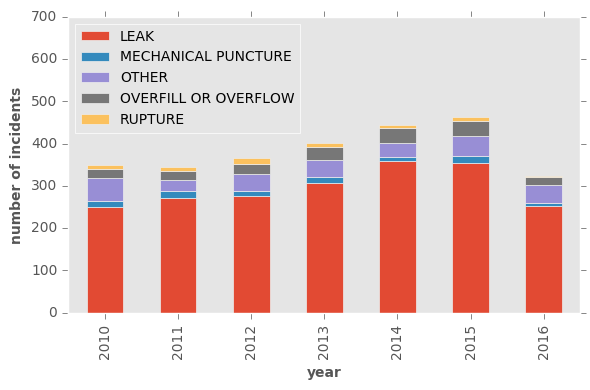

In [7]:
release_year = pd.crosstab(dataset['year'],dataset['release type'])
ax = release_year.plot(kind='bar', stacked=True, grid=False)
ax.set_ylabel("number of incidents")
ax.set_xlabel("year")
ax.legend(loc = 'upper left')
ax.set_ylim(0,700)
plt.tight_layout()
plt.show()

From here on, I will be focused on incidents involving crude oil only. The number of such incidents has constantly increased with the exception of 2011. But the volume released in years follows no such pattern. Also, as dataset clearly mentions, part of the released oil can be recovered but it is not reported in the dataset.

In [178]:
data = dataset[dataset["commodity"]=="CRUDE OIL"]
data.head()

,time,year,lat,long,commodity,volume,state,release type,water,cost,cause,date,ctime
4,2/21/10 12:45,2010,31.13284,-101.18974,CRUDE OIL,378,TX,LEAK,NO,21991.543373,CORROSION FAILURE,2010-02-21,2/21/10 12:45
8,2/20/10 6:30,2010,32.47850,-94.86790,CRUDE OIL,336,TX,OVERFILL OR OVERFLOW,YES,117614.823872,EQUIPMENT FAILURE,2010-02-20,2/20/10 6:30
10,3/1/10 9:16,2010,47.68857,-95.41732,CRUDE OIL,126,MN,OVERFILL OR OVERFLOW,NO,23997.634976,INCORRECT OPERATION,2010-03-01,3/1/10 9:16
13,3/1/10 8:10,2010,32.48325,-94.83034,CRUDE OIL,8316,TX,RUPTURE,NO,20146.442193,CORROSION FAILURE,2010-03-01,3/1/10 8:10
16,1/25/10 11:07,2010,29.47000,-90.25444,CRUDE OIL,8484,LA,OVERFILL OR OVERFLOW,YES,838911.034004,EQUIPMENT FAILURE,2010-01-25,1/25/10 11:07


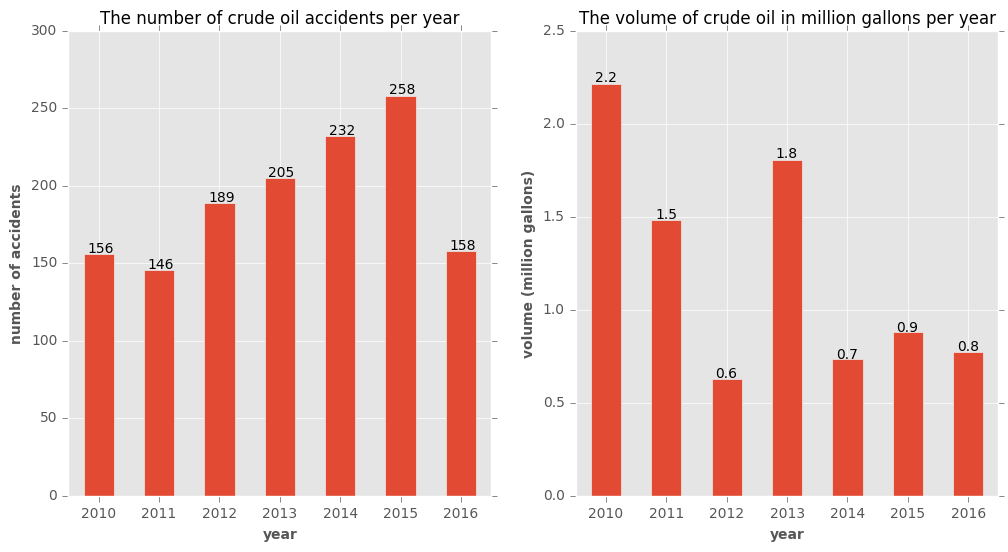

In [188]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
data["year"].value_counts(sort=False).plot(kind='bar',rot=0,ax=axes[0])

axes[0].set_title("The number of crude oil accidents per year")
axes[0].set_ylabel("number of accidents")
axes[0].set_xlabel("year")
for p in axes[0].patches:
    # write number on the bars
    axes[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/8, p.get_height() * 1.005))

(data.groupby(['year'])['volume'].sum()/(10**6)).plot(kind='bar',rot=0,ax=axes[1])
axes[1].set_title("The volume of crude oil in million gallons per year")
axes[1].set_ylabel("volume (million gallons)")
axes[1].set_xlabel("year")
for p in axes[1].patches:
    axes[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x() + p.get_width()/8, p.get_height() * 1.005))
plt.show()

### Which states are dealing with this?

Texas by far has the most spills, followed by Oklahoma, California and Wyoming. In fact Texas and Oklahoma deal with more than %51 of the accidents.

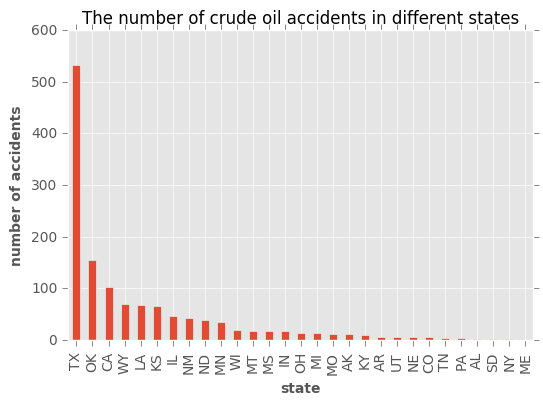

0.51190476190476186

In [190]:
ax=data["state"].value_counts(sort=True).plot(kind='bar')
ax.set_title("The number of crude oil accidents in different states")
ax.set_ylabel("number of accidents")
ax.set_xlabel("state")
plt.show()
# share of the first two states from the incidents
data["state"].value_counts(sort=True,normalize=True)[0:2].sum()

### What is total money spent?

Look at the patterns of cost how it alternative from year to year. Probably because cleaning and fixing the issue takes a long time (maybe about a year?). ALso, the companies are supposed to report the data at the end of fixing and cleaning process, so a lot of incidents are not finished yet. Or not even reported.

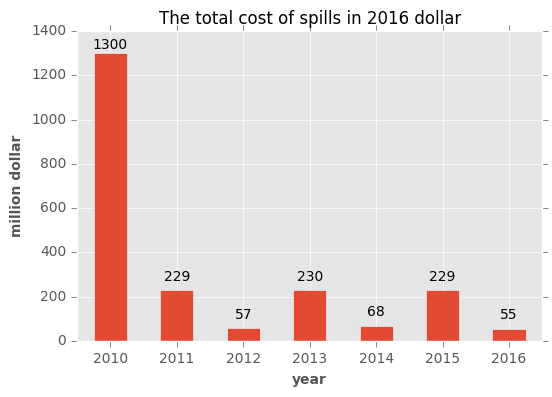

In [12]:
ax = (data.groupby(['year'])['cost'].sum()/10**6).plot(kind='bar',rot=0)
ax.set_title("The total cost of spills in 2016 dollar")
ax.set_ylabel("million dollar")
ax.set_xlabel("year")
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+ p.get_width()/2, p.get_height() * 0.98),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### Was water contaminated?

Maybe the most concerning aspect of spills is whether these spills pollute the water or not. Fortunately, this is often not the cases (in %91 of cases). Although, we don't whether these spills happen close to the water or not. Maybe, we have been lucky that pipelines are not croosing the lands close the water resources.

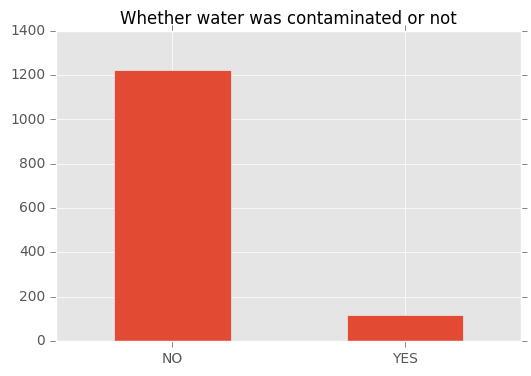

In [194]:
data['water'].value_counts().plot.bar(title="Whether water was contaminated or not",rot=0)
plt.show()

## Geographic distributions

The color intensity represents the number of spills in each states. The color palettes 
on the US map is from [colorbrewer2](http://colorbrewer2.org/). As it was mentioned, Texas is by far the worst state
in terms of number of incididents. 

In [15]:
df = pd.DataFrame(data["state"].value_counts(sort=True).reset_index())
df.columns = ["code","counts"]

In [16]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py

datax = [ dict(
        type='choropleth',
        autocolorscale = False,
        colorscale=[[0, 'rgb(255,237,160)'],[0.5, 'rgb(254,178,76)'],[1, 'rgb(240,59,32)']],
        locations = df["code"],
        z = df["counts"],
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(0,0,0)',width = 1,) ),
        colorbar = dict(title = ""),
        ) ]

layout = dict(
        title = 'The number of spills from 2010-October 2016',  
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(229, 229, 229)",
            subunitcolor = "rgb(0,5,5)",
            countrycolor = "rgb(0,50,5)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )
    
fig = dict( data=datax, layout=layout )
iplot( fig, filename='./d3-cloropleth-map',) #image='png'


### Incidents on map

In [17]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py

datax = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = data['long'],
        lat = data['lat'],
        text = data['cost'].astype(str),
        mode = 'markers',
        hoverinfo = 'lon+lat+location',
        marker = dict( 
            size = 9,
            symbol = 'circle',
            line = dict(width=1,color='rgba(10, 10, 1)'),
            opacity = 0.9,
            reversescale = False,
            autocolorscale = False,
            colorscale=[[0, 'rgb(255,237,160)'],[0.5, 'rgb(254,178,76)'],[1, 'rgb(240,59,32)']],
            cmin = 0,
            color = data['volume'],
            cmax = data['volume'].max(),
            colorbar=dict(title="Gallons"),
        ))]

layout = dict(
        title = 'All crude oil incidents from 2010-October 2016',   
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(229, 229, 229)",
            subunitcolor = "rgb(0,5,5)",
            countrycolor = "rgb(0,50,5)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = dict( data=datax, layout=layout )
iplot( fig, filename='d3-airports' )

## Conclusion
During the period 2010 to October 2016, more than 8.5 million gallons of crude oil is spilled. The cost of this spill is well over 2 billion dollars. In one of the worst cases, 843444 gallons was released in Michigan, resulting in a massive 1 billion loss in 2016 dollars and water contamination. In 2016 alone, more than 54 million dollars has been the cost of releasing 800000 pipeline incidents.

I cannot confirm or deny that an incident happens within an operator's facility, as [pipeline101 claims](http://www.pipeline101.com/are-pipelines-safe). At the time that I am writing this rpeort, there are [188 federal and 340 state inspectors](http://phmsa.dot.gov/pipeline/inspections).

## Furthur ideas
There are many other aspcts in these data that can be explored. The number of injuries, underground/aboveground, possible seasonal/temporal patterns.

Whether the spill happened close to the well or along the pipeline. This is important as I guess most wells are located at distant points from cities but pipelines can easily cross lands close to farming and cities.
How quickly they responded? Which one has a bigger effect on the environment?
What is the number of casualties in the accidents (important point is missing)?

I'll be grateful to head comments/ideas/?

It would be better to have the actual cost of the spill rather having 2016 dollars!

Relatonship cost with commodity?

In [9]:
temp = pd.to_datetime(dataset['time'])

dataset['date'] = temp.dt.date
dataset['date'] = dataset['date'].astype(str)
dataset['ctime'] = temp.dt.time
dataset['ctime'] = dataset['time'].astype(str)

In [62]:
mapdic = {}
for key in enumerate(dataset.commodity.unique()):
    mapdic[key[1]]=key[0]
colors = dataset.commodity.replace(mapdic, inplace=False)
,c=colors,cmap=plt.cm.RdBu

NameError: name 'c' is not defined

In [ ]:
#for c in ['#E24A33', '#348ABD', '#777777', '#FBC15E', '#8EBA42']:

With that being said, it should be interesting to see if the volume and cost are correlated

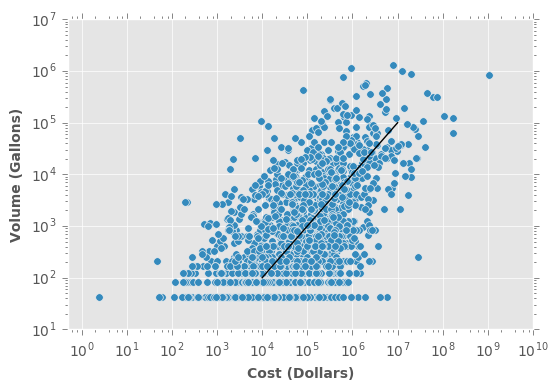

In [168]:
ax = dataset.plot.scatter(x='cost', y='volume', s=30)
m,b = np.polyfit(dataset.volume, dataset.cost, 1)
x = np.logspace(4,7,5)
plt.loglog(x,0.01*x,'-k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.5,10**10)
ax.set_ylim(10**1,10**7)
ax.set_xlabel('Cost (Dollars)')
ax.set_ylabel('Volume (Gallons)')
plt.show()